In [31]:
import pandas as pd
import torch
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
import torch.nn as nn
from torchvision import datasets
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader
from torch import optim
import matplotlib.pyplot as plt

## Data loader

In [32]:
"""
Data loader

1. Read the data from the CSV file
    We'll use the pandas library to read the CSV file and then transform the data into PyTorch tensors.

2. Splitting the dataset
    We'll use the train_test_split function from sklearn to split the data into training, validation, and test sets. For demonstration purposes, we'll split the data as follows:

    70% Training
    15% Validation
    15% Test

3. Creating Dataloaders
    Once we've split the data, we'll convert each set into a PyTorch TensorDataset and then use the DataLoader class to create loaders for each set.
"""

# 1. Read data from the CSV file
data = pd.read_csv('MNIST_dataset.csv')
labels = torch.tensor(data.iloc[:, -1].values, dtype=torch.long)
images = torch.tensor(data.iloc[:, 1:].values, dtype=torch.float32).reshape(-1, 1, 28, 28) / 255.0  # normalize to [0, 1] range

# 2. Split the dataset
X_train, X_temp, y_train, y_temp = train_test_split(images, labels, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# 3. Create Dataloaders
train_dataset = TensorDataset(X_train, y_train)
val_dataset = TensorDataset(X_val, y_val)
test_dataset = TensorDataset(X_test, y_test)

batch_size = 100
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

loaders = {
    'train': train_loader,
    'val': val_loader,
    'test': test_loader,
}

## Model

In [33]:
"""
Model
1. Develop Deep Learning Models
We'll create two models based on the given requirements:

A model with one CNN block
A model with two CNN blocks

2. Train and Evaluate Models
We'll use the provided training loop and modify it slightly to evaluate on the validation set. Here's a function to train and evaluate:

3. Make Predictions
Use the test function provided in the original code to make predictions on new images.

4. Tweak Network's Hyper-parameters to Overfit and Underfit
To overfit:

Reduce the size of the dataset.
Increase the complexity of the model by adding more layers or increasing the number of channels.
Increase the number of epochs.
Do not use any form of regularization (like dropout).
To underfit:

Use a very simple model (like only one CNN block with fewer channels).
Use very few epochs.
Introduce high regularization (like high dropout rates).
To achieve overfitting or underfitting, you can play around with the model architectures and the training configurations.
"""

class CNN_OneBlock(nn.Module):
    def __init__(self):
        super(CNN_OneBlock, self).__init__()
        self.conv_block1 = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.fc = nn.Linear(16*14*14, 10)
    
    def forward(self, x):
        x = self.conv_block1(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

class CNN_TwoBlocks(nn.Module):
    def __init__(self):
        super(CNN_TwoBlocks, self).__init__()
        self.conv_block1 = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv_block2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.fc = nn.Linear(32*7*7, 10)
    
    def forward(self, x):
        x = self.conv_block1(x)
        x = self.conv_block2(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x
    
loss_func = nn.CrossEntropyLoss()

In [34]:
def train_and_evaluate(num_epochs, model, loaders, optimizer, loss_func, print_info=True):
    training_losses = []
    validation_losses = []

    # Train
    model.train()
    total_step = len(loaders['train'])
    for epoch in range(num_epochs):
        epoch_loss = 0.0
        for i, (images, labels) in enumerate(loaders['train']):
            output = model(images)
            loss = loss_func(output, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
        
        average_epoch_loss = epoch_loss / total_step
        training_losses.append(average_epoch_loss)
        
        # Evaluate
        model.eval()
        validation_loss = 0.0
        correct = 0
        total = 0
        with torch.no_grad():
            for images, labels in loaders['val']:
                outputs = model(images)
                loss = loss_func(outputs, labels)
                validation_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        
        average_validation_loss = validation_loss / len(loaders['val'])
        validation_losses.append(average_validation_loss)

        if print_info is True:
            print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {average_epoch_loss:.4f}, Validation Loss: {average_validation_loss:.4f}, Validation Accuracy: {100 * correct / total:.2f}%')

    return training_losses, validation_losses


# Overfitting
overfit_model = CNN_TwoBlocks()  # or another complex architecture
optimizer = optim.Adam(overfit_model.parameters(), lr=0.01)
train_and_evaluate(200, overfit_model, loaders, optimizer, loss_func)  # Use more epochs

# Underfitting
underfit_model = CNN_OneBlock()  # or an even simpler architecture
optimizer = optim.Adam(underfit_model.parameters(), lr=0.01)
train_and_evaluate(10, underfit_model, loaders, optimizer, loss_func);  # Use very few epochs

Epoch [1/200], Loss: 2.4284, Validation Loss: 2.2618, Validation Accuracy: 16.67%
Epoch [2/200], Loss: 2.1822, Validation Loss: 2.1507, Validation Accuracy: 30.00%
Epoch [3/200], Loss: 1.9175, Validation Loss: 1.8679, Validation Accuracy: 33.33%
Epoch [4/200], Loss: 1.3137, Validation Loss: 1.1802, Validation Accuracy: 56.67%
Epoch [5/200], Loss: 0.7123, Validation Loss: 1.0548, Validation Accuracy: 66.67%
Epoch [6/200], Loss: 0.4464, Validation Loss: 0.8740, Validation Accuracy: 76.67%
Epoch [7/200], Loss: 0.5248, Validation Loss: 1.0229, Validation Accuracy: 66.67%
Epoch [8/200], Loss: 0.3121, Validation Loss: 0.9259, Validation Accuracy: 70.00%
Epoch [9/200], Loss: 0.1911, Validation Loss: 1.1495, Validation Accuracy: 70.00%
Epoch [10/200], Loss: 0.1421, Validation Loss: 0.7656, Validation Accuracy: 80.00%
Epoch [11/200], Loss: 0.0562, Validation Loss: 0.6485, Validation Accuracy: 76.67%
Epoch [12/200], Loss: 0.0488, Validation Loss: 0.5665, Validation Accuracy: 80.00%
Epoch [13/200

## Optimization

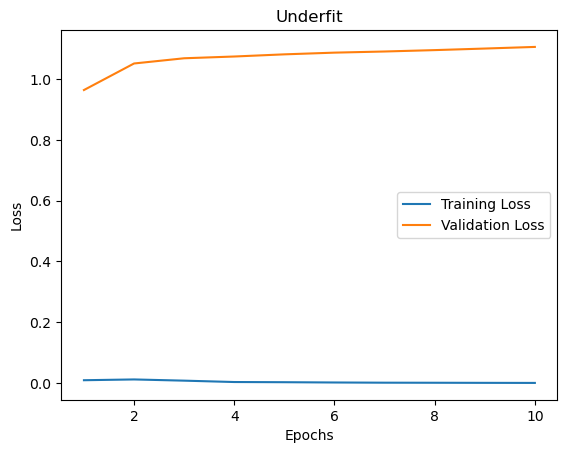

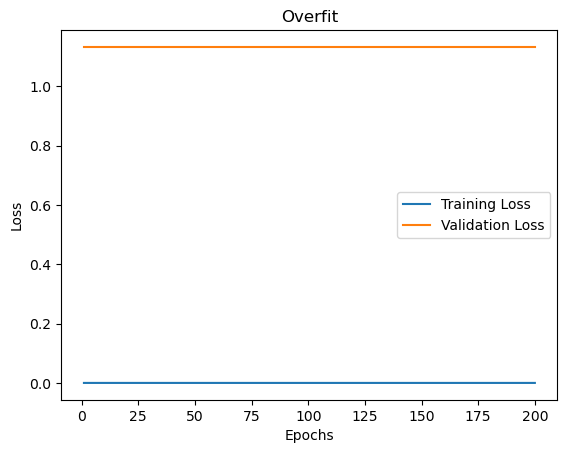

In [35]:
def plot_learning_curves(training_losses, validation_losses, title="title"):
    epochs = len(training_losses)
    plt.plot(range(1, epochs+1), training_losses, label='Training Loss')
    plt.plot(range(1, epochs+1), validation_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.title(title)
    plt.show()

# Underfitting learning curve
underfit_training_losses, underfit_validation_losses = train_and_evaluate(10, underfit_model, loaders, optimizer, loss_func, print_info=False)
plot_learning_curves(underfit_training_losses, underfit_validation_losses, "Underfit")

# Overfitting learning curve
overfit_training_losses, overfit_validation_losses = train_and_evaluate(200, overfit_model, loaders, optimizer, loss_func, print_info=False)
plot_learning_curves(overfit_training_losses, overfit_validation_losses, "Overfit")